In [1]:
import torch
from torch.utils.data import Dataset, DataLoader


In [82]:
from pathlib import Path
import os
import shutil
import tqdm
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Union



In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [4]:
lidar_images = Path("/cluster/projects/vc/data/ad/open/Poles")

In [5]:
import os

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
            break

print_directory_structure(str(lidar_images))


Poles/
    README.dataset.txt
    test/
        labels/
            combined_image_977_png.rf.c5f3053e13600d351f6be75e1b9757a5.txt
        images/
            combined_image_252_png.rf.135ceef664dba8daecdb41f98d115755.jpg
    train/
        .DS_Store
        labels/
            Image00658_rgb_png.rf.924d3162454c4a246eb1a7dbcc3b4400.txt
        images/
            combined_image_1249_png.rf.545e8638623ae9229dd267c0b1bbae68.jpg


In [6]:
model = YOLO("yolo11s.pt")

In [7]:
if not (Path.cwd() / "data").exists():
    tqdm.tqdm(shutil.copytree(lidar_images, Path.cwd() / "data"))
    print(f"Files copied to {Path.cwd() / 'data'}")
else:
    print(f"Files already present in {Path.cwd() / 'data'}")

Files already present in /cluster/home/jofa/tdt17/TDT17-mini-project/data


In [47]:
img_path = "data/test/images/combined_image_5_png.rf.9372598b5abf9cfff473ec530fdbf7be.jpg"
coord_path = "data/test/labels/combined_image_5_png.rf.9372598b5abf9cfff473ec530fdbf7be.txt"

double_coords_path = "data/test/labels/combined_image_13_png.rf.7390c64ced5859039424843ebf4207f9.txt"

In [ ]:
#this only works for files with a single line of coordinates

def get_coords(file_path):
    with open(file_path, 'r') as file:
        file_contents = file.read()
        
        
    if "\n" in file_contents:
        # print(f"File {file_path} contains multiple lines of coordinates")
        file_contents = file_contents.split("\n")
        # print(f"file_contents: {file_contents}")
        for i, index in enumerate(file_contents):
            file_contents[i] = index.split(" ")
            for j, index2 in enumerate(file_contents[i]):
                file_contents[i][j] = float(index2)
        return file_contents
    else:    
        file_contents = file_contents.split(" ")
        for i, index in enumerate(file_contents):
            file_contents[i] = float(index)
        return [file_contents, None]


print(f"Function output:\n{get_coords(coord_path)}")
print(f"Function output:\n{get_coords(double_coords_path)}")

print(f"Expected coords:\n0 0.42138671875 0.74609375 0.0068359375 0.2421875\n0 0.5244140625 0.6484375 0.00537109375 0.1640625")

Function output:
[[0.0, 0.21875, 0.9140625, 0.0078125, 0.171875], None]
Function output:
[[0.0, 0.42138671875, 0.74609375, 0.0068359375, 0.2421875], [0.0, 0.5244140625, 0.6484375, 0.00537109375, 0.1640625]]
Expected coords:
0 0.42138671875 0.74609375 0.0068359375 0.2421875
0 0.5244140625 0.6484375 0.00537109375 0.1640625


0
1


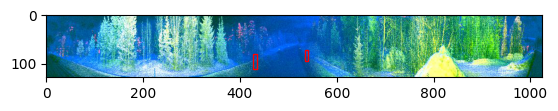

In [101]:
def show_boxes(image, box_coords):
    
    # print(f"Box coords: {box_coords}")
    fig, ax = plt.subplots()
    for i, box in enumerate(box_coords):
        # print(f"Box {i}: {box}")
        if box is None:
            # print("Finished printing rectangles")
            pass
        else:
            print(i)
            _, x_center, y_center, width, height = box
            
            # print(f"Image shape: {image.shape[:2]}")
            img_height, img_width = image.shape[:2]
            
            
            # print(f"Box coordinates:  x_center: {x_center}, y_center: {y_center}, width: {width}, height: {height}")
            # print(f"Type: {type(x_center)}")

            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            
            # print(f"Box coordinates:  x_center: {x_center}, y_center: {y_center}, width: {width}, height: {height}")
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
            
            ax.add_patch(rect)
    
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)
    plt.imshow(image)
    
    plt.pause(0.001)
    
show_boxes(plt.imread(img_path), get_coords(double_coords_path))

In [102]:
class LidarDataset(Dataset):
    """Custom dataset for LiDAR images"""
    
    def __init__(self, img_dir:Union[Path, str], coord_dir:Union[Path, str], transform=None):
        
        self.img_dir = img_dir
        self.coord_dir = coord_dir
        self.transform = transform
        
        self.images = os.listdir(img_dir)
        self.coords = os.listdir(coord_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = os.path.join(self.img_dir, self.images[idx])
        coord_path = os.path.join(self.coord_dir, self.coords[idx])
        
        image = plt.imread(img_path)
        coords = get_coords(coord_path)
        
        if coords[-1] == None:
            coords = coords[:-1]
        
        if self.transform:
            image = self.transform(image)
        
        print(f"Image path: {img_path}")
        return image, coords

In [103]:
# results = model.train(data=(Path.cwd()/"data"/ "data.yaml"), epochs=3, device=device)

Image path: data/test/images/combined_image_252_png.rf.135ceef664dba8daecdb41f98d115755.jpg
0
1


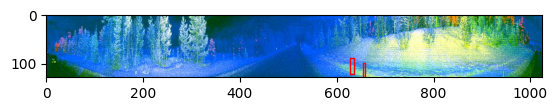

Image path: data/test/images/combined_image_1239_png.rf.f1013f02669a0292702a072eef60ad9e.jpg
0
1


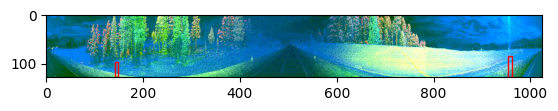

Image path: data/test/images/combined_image_1980_png.rf.194b20b71494dc13e0beb6815c474808.jpg
0


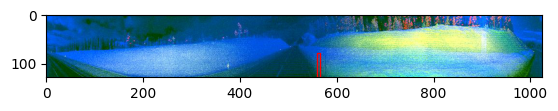

Image path: data/test/images/combined_image_1011_png.rf.38b83aea7c4e85230d477d08b4d902b5.jpg
0
1
2
3


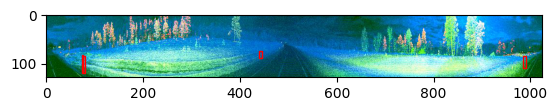

Image path: data/test/images/combined_image_457_png.rf.19432a60bfa321b42a96321ca0f7f71a.jpg
0
1
2


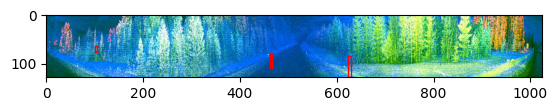

Image path: data/test/images/combined_image_123_png.rf.3fbff76e057b70542d6a180d44b3fb23.jpg
0
1
2


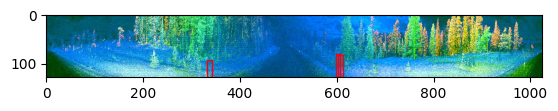

In [104]:
lidar_dataset = LidarDataset(Path("data/test/images"), Path("data/test/labels"))

for i, sample in enumerate(lidar_dataset):
    show_boxes(sample[0], sample[1])
    if i == 5:
        break